# Contours in OpenCV

In [28]:
!pip install opencv-python==4.5.5.64
!pip install watermark

The official tutorial on contours in OpenCV can be found
[here](https://docs.opencv.org/4.x/d3/d05/tutorial_py_table_of_contents_contours.html).
We’ll summarize some important methods discussed in this notebook, using
the image below as an example.

In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

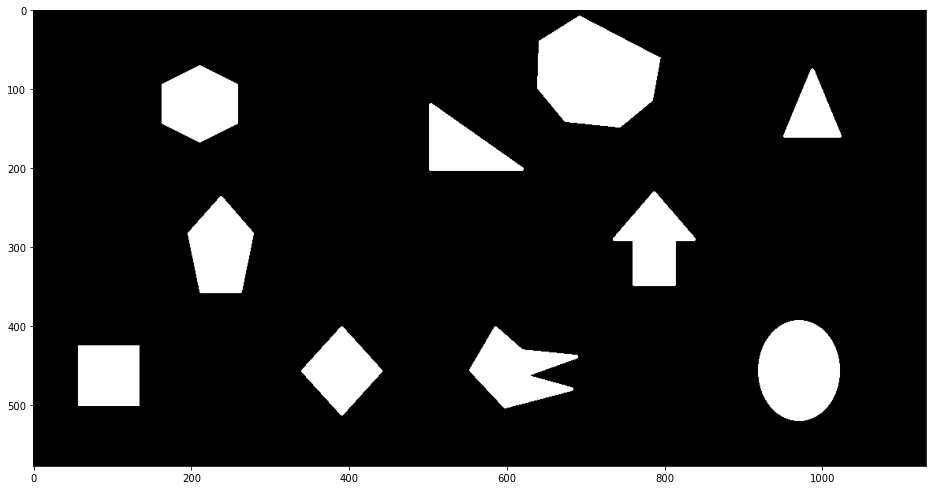

In [6]:
def display_image(img):
    fig, ax = plt.subplots(figsize=(16,16))
    ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show() 

img = cv.imread("FindingContours.png")
display_image(img)

Normally before finding contours in an image the image has to be
binarized using a threshold algorithm, or canny edge detection. But in
this case the image is already binarized, as the following calculation
shows.

In [7]:
print("Shape: ", img.shape)
# The image pixels only take 2 values, hence it's binarized.
print("Values: ", np.unique(img))

Shape:  (578, 1132, 3)
Values:  [  0 255]

We’ll first convert the image to gray scale.

In [8]:
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray.shape

(578, 1132)

Now find contours using the `cv.CHAIN_APPROX_NONE` method. This requires
more memory but the following methods tend to be more robust (this
includes convexity checking and orientation finding methods).

In [9]:
contours, _ = cv.findContours(gray, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
len(contours)

10

Label the contours so we can refer to them later. The first method we’ll
use below is `contourArea` to filter out noise. We’ll also use `moments`
to calculate the contours centroid.

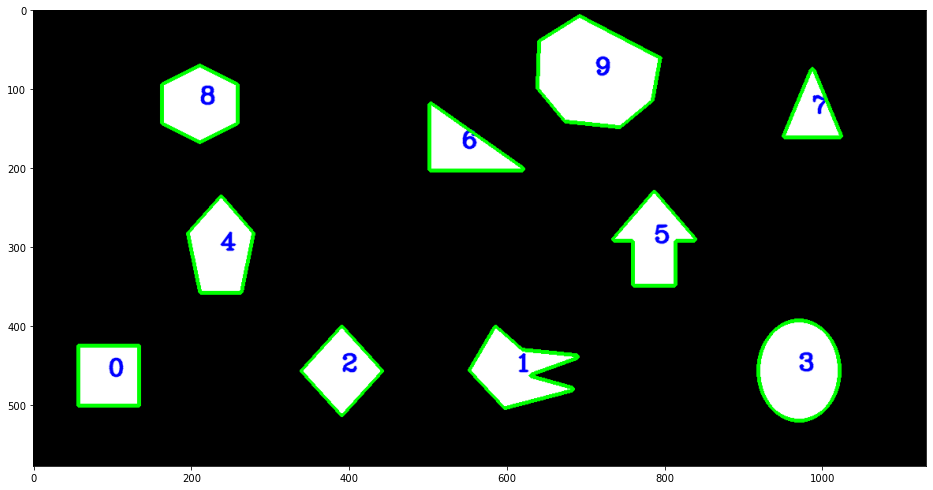

In [10]:
mimg = img.copy()
# Go through all non-trivial contours and label them.
for i, contour in enumerate(contours):
    area = cv.contourArea(contour)

    if area < 1e2 or area > 1e5:
        continue

    moments = cv.moments(contour)
    cx, cy = int(moments["m10"]/moments["m00"]), int(moments["m01"]/moments["m00"])

    mimg = cv.putText(mimg, str(i), (cx,cy), cv.FONT_HERSHEY_COMPLEX, 
                      1, (255,0,0), 2, cv.LINE_AA)

# Replace -1 with the contour index to draw a specific contour.                
cv.drawContours(mimg, contours, -1, (0,255,0), 3)
display_image(mimg)

Now we’ll calculate several contour properties, including convexity,
area, perimeter and angle. An important detail to keep in mind is that
image coordinates have clockwise orientation (in contrast with Cartesian
coordinates which are counter-clockwise). So for example, an angle of 10
degrees, lies in the quadrant with positive $x$ and $y$ values. See
[this](https://docs.opencv.org/4.5.5/dd/d49/tutorial_py_contour_features.html)
tutorial for further details.

<figure>
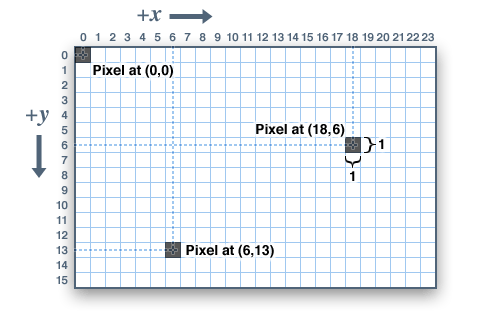
<figcaption aria-hidden="true">image coordinates</figcaption>
</figure>

In [11]:
for i, contour in enumerate(contours):
    area = cv.contourArea(contour)

    if area < 1e2 or area > 1e5:
        continue

    # isContourConvex doesn't work so well and depends on the chain approx
    # method.
    isconvex = cv.isContourConvex(contour)
    perimeter = cv.arcLength(contour, True)
    # We'll use the angle returned by fitEllipse
    _, _, angle = cv.fitEllipse(contour)   
    print(f"{i} IsConvex: {isconvex}, Area: {area:.2f}, Perimeter: {perimeter:.2f}, Angle: {angle:.2f}")

0 IsConvex: False, Area: 5852.00, Perimeter: 306.00, Angle: 90.00
1 IsConvex: False, Area: 7104.50, Perimeter: 485.49, Angle: 19.44
2 IsConvex: False, Area: 5920.00, Perimeter: 310.84, Angle: 45.00
3 IsConvex: False, Area: 10290.00, Perimeter: 382.68, Angle: 90.00
4 IsConvex: False, Area: 7119.50, Perimeter: 343.81, Angle: 90.00
5 IsConvex: False, Area: 6518.00, Perimeter: 382.74, Angle: 40.76
6 IsConvex: False, Area: 5357.50, Perimeter: 358.21, Angle: 0.00
7 IsConvex: False, Area: 3375.00, Perimeter: 276.65, Angle: 90.00
8 IsConvex: False, Area: 7056.00, Perimeter: 329.76, Angle: 90.00
9 IsConvex: False, Area: 15776.50, Perimeter: 492.66, Angle: 27.55

Below we’ll use `boundingRect` to draw bounding boxes around the
contours.

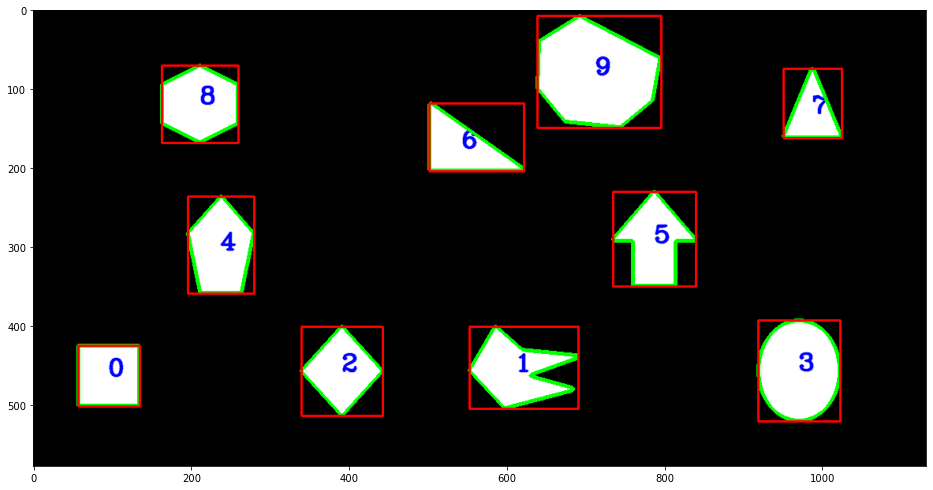

In [13]:
for contour in contours:
    x,y,w,h = cv.boundingRect(contour)

    cv.rectangle(mimg, (x,y), (x+w, y+h), (0,0,255),2)

display_image(mimg)

Now we’ll consider another method called `minAreaRect`, which calculates
the rectangle enclosing the contour with minimal area.

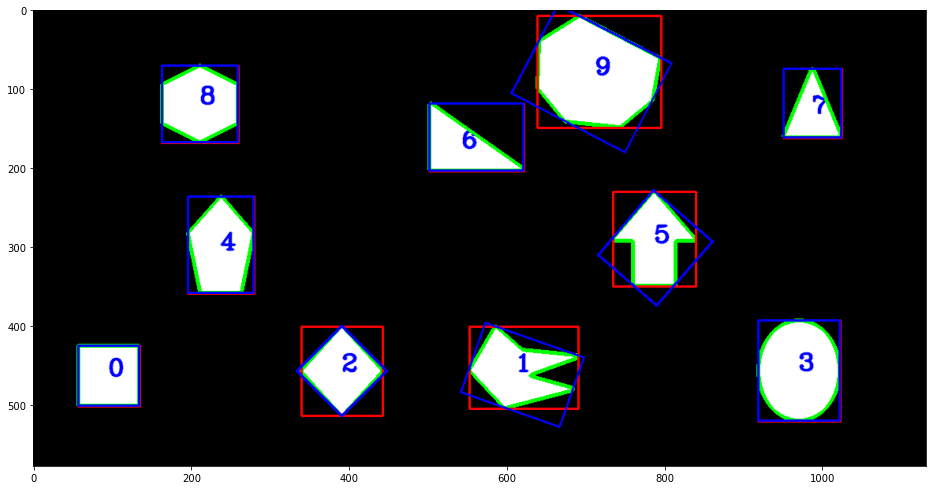

In [14]:
for contour in contours:
    area = cv.contourArea(contour)

    if area < 1e2 or area > 1e5:
        continue

    # rect is the following tuple: ( center (x,y), (width, height), angle of rotation )
    rect = cv.minAreaRect(contour)
    # Need to get verticies to draw the rectangle.
    box = cv.boxPoints(rect)
    box = np.int0(box)

    cv.drawContours(mimg, [box], 0, (255,0,0), 2)

display_image(mimg)

At this point we’ve seen two methods that give an orientation of a
contour. The first was `fitEllipse`, and then `minAreaRect`. Finally
we’ll use `PCACompute2`[1] (see [Introduction to
PCA](https://docs.opencv.org/4.5.5/d1/dee/tutorial_introduction_to_pca.html))
for a third method for obtaining the contour orientation and compare it
with the former methods.

[1] Note that the contour was converted to floats before passing it to
PCACompute2. This is a consistent pattern throughout opencv-python that
the appropriate data type has to be used.

In [18]:
for i, contour in enumerate(contours):
    area = cv.contourArea(contour)

    if area < 1e2 or area > 1e5:
        continue
        
    print(f"Contour {i}")
    _,_, angle_minor = cv.fitEllipse(contour)
    print(f"fitEllipse angle: {angle_minor:.2f}")
    _, _, angle_rect = cv.minAreaRect(contour)  
    print(f"minAreaRect angle: {angle_rect:.2f}") 

    mean = np.empty((0))
    mean, eigenvectors, eigenvalues = cv.PCACompute2(contour.squeeze().astype(np.float64), mean)

    # Compare with angles from PCA.
    print("PCA angles", [ round(num, 2) for num in cv.phase(eigenvectors[:,0], eigenvectors[:,1], angleInDegrees=True).reshape(-1)] )
    print("")

Contour 0
fitEllipse angle: 90.00
minAreaRect angle: 90.00
PCA angles [0.0, 90.0]

Contour 1
fitEllipse angle: 98.17
minAreaRect angle: 19.44
PCA angles [10.81, 100.81]

Contour 2
fitEllipse angle: 0.04
minAreaRect angle: 45.00
PCA angles [89.99, 359.99]

Contour 3
fitEllipse angle: 0.09
minAreaRect angle: 90.00
PCA angles [90.05, 0.05]

Contour 4
fitEllipse angle: 0.15
minAreaRect angle: 90.00
PCA angles [90.38, 0.38]

Contour 5
fitEllipse angle: 0.03
minAreaRect angle: 40.76
PCA angles [90.02, 0.02]

Contour 6
fitEllipse angle: 116.06
minAreaRect angle: 0.00
PCA angles [27.48, 117.48]

Contour 7
fitEllipse angle: 0.01
minAreaRect angle: 90.00
PCA angles [90.05, 0.05]

Contour 8
fitEllipse angle: 90.00
minAreaRect angle: 90.00
PCA angles [0.0, 90.0]

Contour 9
fitEllipse angle: 109.28
minAreaRect angle: 27.55
PCA angles [17.31, 107.31]


Note that the PCA angles are the angles made by the semi-major and
semi-minor axis of the PCA ellipse about the x-axis. The above
calculations suggest that `fitEllipse` returns the angle made by the
semi-minor axis of the PCA ellipse (also see
[here](https://datascience.stackexchange.com/questions/85064/where-is-the-rotated-angle-actually-located-in-fitellipse-method)).
Due to this simple geometric interpretation, we use the angle returned
by `fitEllipse` to represent the orientation of the contour.

In [5]:
%load_ext watermark
%watermark --iversions -v

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.31.0

cv2       : 4.5.5
numpy     : 1.19.5
matplotlib: 3.5.1
